# SuperflexPy example 12: Changing M4 of Kavetski et al., 2011

Author: Marco Dal Molin

Collaborators: Fabrizio Fenicia, Dmitri Kavetski

## What's in this example

This example will cover the following aspects:
- [Modify the model M4 presented in Kavetski and Fenicia, 2011](https://superflexpy.readthedocs.io/en/latest/build_element.html#linear-reservoir)

By clicking on the items you will be redirected to the documentation page (when available) that explains the arguments in a more detailed way.

REFERENCE: Kavetski, D., and F. Fenicia (2011), Elements of a flexible approach for conceptual hydrological modeling: 2. Application
and experimental insights, Water Resour. Res., 47, W11511, [doi:10.1029/2011WR010748](https://doi.org/10.1029/2011WR010748)

## What's not in this example

The following aspects are already covered in other examples:

- [Initialize elements and connect them with a unit](./04_init_single_unit_model.ipynb)
- [Run the model](./01_run_simple_model.ipynb)
- [Change states and parameters](./01_run_simple_model.ipynb)
- [Implement a new element from scratch](./07_create_reservoir.ipynb)

For this reason we will put only the code need, without further explanations. You can check the other examples by clicking on the items above.

## Do you want to use this example as a script?

Examples of SuperflexPy are created and distributed using Jupyter notebooks because they enable to conjugate runnable code with text explanations. We have decided to not provide the content of the notebooks as script because this would mean duplicating the same content in multiple places, bringing to maintainability problems.

If the user wants to download the content of this notebook as a python script, it is possible following the steps:
1. If not already done, open this notebook using [Binder](https://mybinder.org/v2/gh/dalmo1991/superflexPy/master?filepath=examples%2F12_M4_sfPaper_changed.ipynb)
2. Go on File -> Download as -> Python (.py)
3. Select the saving path

The result is a Python script that contains all the markdown text as comment and the code contained inside the cells.

## STEP 0: Import of external libraries

The execution of the code in this example relies on the following external libraries:
- **numpy**: arrays handling
- **numba**: runtime compiler

We assume that those libraries are already installed together with the latest version of SuperflexPy. Keep in mind that not all the libraries listed above are strictly needed to execute SuperflexPy and, therefore, they are not listed as requirements of SuperflexPy.

In [1]:
import numpy as np
import numba as nb

## STEP 1: Create the new element

In this example we implement some changes to the model M4 of Kavetski et al., 2011. The difference is in the calculation of the outflow of the `FastReservoir`. 

The original equation used in the paper is
$$Q=kS^\alpha$$
In the new implementation we propose to use the equation
$$Q=\frac{kS^\alpha}{S + b}$$

### 01. Implement a new element (in a smart way)

The normal procedure for implementing a new element is illustrated in [this example](TODO). The new element can be implemented following the procedure illustrated there but, in this particular case, we can notice that it is identical to the `FastReservoir` (same input and output) apart from the equation use for the outflow. For this reason, we can take a shortcut and implement the new element directly extending the class `FastReservoir` instead of `ODEsElement` (as done in the usual case).

This requires overriding only the methods that implement the fluxes, in particular:
- `_fluxes_function_python`
- `_fluxes_function_numba`

We do not change the initializer `__init__()` because the only change would be only in the documentation and not in the functionality. When creating a new element it would good practice to override it (for documentation purposes) but, for this example, we do not do it.

In [2]:
from superflexpy.implementation.elements.hbv import FastReservoir

class ExponentialReservoir(FastReservoir):
    
    @staticmethod
    def _fluxes_function_python(S, S0, ind, P, k, alpha, b):

        if ind is None:
            return (
                [
                    P,
                    - (k * S ** alpha) / (S + b),
                ],
                0.0,
                S0 + P
            )
        else:
            return (
                [
                    P[ind],
                    - (k[ind] * S ** alpha[ind]) / (S + b[ind]),
                ],
                0.0,
                S0 + P[ind]
            )

    @staticmethod
    @nb.jit('Tuple((UniTuple(f8, 2), f8, f8))(optional(f8), f8, i4, f8[:], f8[:], f8[:], f8[:])',
            nopython=True)
    def _fluxes_function_numba(S, S0, ind, P, k, alpha, b):
        # This method is used only when solving the equation

        return (
            (
                P[ind],
                - (k[ind] * S ** alpha[ind]) / (S + b[ind]),
            ),
            0.0,
            S0 + P[ind]
        )

## STEP 1: Initialize the model

The model M4 is composed by 2 elements in series: an unsaturated reservoir and a fast reservoir. Both elements have already been implemented and can be imported from `superflexpy.implementation.elements.hbv`.

In [3]:
from superflexpy.implementation.computation.pegasus_root_finding import PegasusPython
from superflexpy.implementation.computation.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.elements.hbv import UnsaturatedReservoir
from superflexpy.framework.unit import Unit

root_finder = PegasusPython()
numeric_approximator = ImplicitEulerPython(root_finder=root_finder)

ur = UnsaturatedReservoir(
    parameters={'Smax': 50.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 25.0},
    approximation=numeric_approximator,
    id='UR'
)

fr = ExponentialReservoir(
    parameters={'k': 1.0, 'alpha': 1.5, 'b': 5.0},
    states={'S0': 10.0},
    approximation=numeric_approximator,
    id='FR'
)

model = Unit(
    layers=[
        [ur],
        [fr]
    ],
    id='M4'
)

## STEP 2: Run the model

Now that the mode has been initialized, it can be run. This can be done running the code in the following cell.

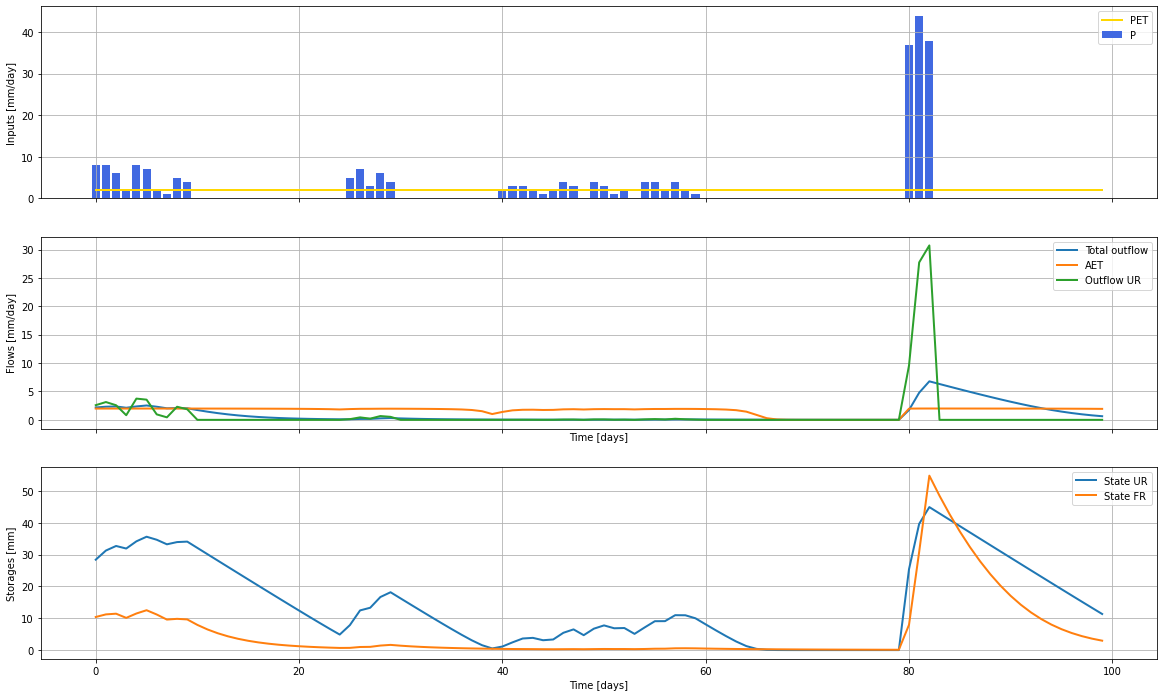

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Fix the seed
SEED = 2
rng = np.random.RandomState(seed=SEED)

# Generate the input
P = np.zeros(100)
P[:10] = rng.randint(10, size=10)
P[25:30] = rng.randint(20, size=5)
P[40:60] = rng.randint(5, size=20)
P[80:83] = rng.randint(30, 50, size=3)
E = np.ones_like(P) * 2.0 # We use a constant PET

# Assign the input
model.set_input([P, E])

# Set the timestep
model.set_timestep(1.0)

# Run the model
model.reset_states()
output = model.get_output()

# Inspect internals
ur_out = model.call_internal(id='UR', method='get_output', solve=False)[0]
ur_e = model.call_internal(id='UR', method='get_AET')[0]
ur_s = model.get_internal(id='UR', attribute='state_array')[:, 0]
fr_s = model.get_internal(id='FR', attribute='state_array')[:, 0]

# Plot
fig, ax = plt.subplots(3, 1, figsize=(20, 12), sharex=True)
ax[0].bar(x=np.arange(len(P)), height=P, color='royalblue', label='P')
ax[0].plot(np.arange(len(P)), E, lw=2, color='gold', label='PET')
ax[0].legend()
ax[0].set_ylabel('Inputs [mm/day]')
ax[0].grid(True)
ax[1].plot(np.arange(len(P)), output[0], lw=2, label='Total outflow')
ax[1].plot(np.arange(len(P)), ur_e, lw=2, label='AET')
ax[1].plot(np.arange(len(P)), ur_out, lw=2, label='Outflow UR')
ax[1].set_xlabel('Time [days]')
ax[1].set_ylabel('Flows [mm/day]')
ax[1].legend()
ax[1].grid(True)
ax[2].plot(np.arange(len(P)), ur_s, lw=2, label='State UR')
ax[2].plot(np.arange(len(P)), fr_s, lw=2, label='State FR')
ax[2].set_xlabel('Time [days]')
ax[2].set_ylabel('Storages [mm]')
ax[2].legend()
ax[2].grid(True)
pass